# DataScience for Good: DonersChoose.org

The below will include the kernel for an investigation into the doner modelling from the data publicly available at Kaggle - https://www.kaggle.com/donorschoose/io/data


The problem description from Kaggle:

A good solution will enable DonorsChoose.org to build targeted email campaigns recommending specific classroom requests to prior donors. Part of the challenge is to assess the needs of the organization, uncover insights from the data available, and build the right solution for this problem. Submissions will be evaluated on the following criteria:

    Performance - How well does the solution match donors to project requests to which they would be motivated to donate? DonorsChoose.org will not be able to live test every submission, so a strong entry will clearly articulate why it will be effective at motivating repeat donations.

    Adaptable - The DonorsChoose.org team wants to put the winning submissions to work, quickly. Therefore a good entry will be easy to implement in production.

    Intelligible - A good entry should be easily understood by the DonorsChoose.org team should it need to be updated in the future to accommodate a changing marketplace.


## Working with the data

This Notebook will explore the Donations.csv provided by DonorsChoose.org partnered with Google.org and document the process that will begin with performing basic descriptive statistics, to finalising a survival model which will predict the likelihood of donor dropoff.

Follow along in your own python session if you want to have ago yourself. I'm working in Python 3.5 right now, my admin has been slacking recently XD. You'll need the following packages installed with pip:

numpy
pandas
matplotlib



In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import gc

gc.collect()

columns = ['Project ID',
          'Donation ID',
          'Donor ID',
          'Donation Included Optional Donation',
          'Donation Amount',
          'Donor Cart Sequence',
          'Donation Received Date']

dtypes = {'Project ID': object,
          'Donation ID': object,
          'Donor ID': object,
          'Donation Included Optional Donation': object,
          'Donation Amount': np.float64,
          'Donor Cart Sequence': np.float64,
          'Donation Received Date': object}

PATH = '../'
#PATH = '/home/mj/datawarehouse/io'

#needed header=0 as names was passed to the function, but first line of csv contains column titles. This ensures they're not converted
donations = pd.read_csv(PATH+'/Donations.csv', names = columns, header=0, dtype = dtypes, infer_datetime_format=True, parse_dates=True, low_memory=False)
donors = pd.read_csv(PATH+'/Donors.csv', header=0, infer_datetime_format=True, parse_dates=True, low_memory=False)
#projects = pd.read_csv(PATH+'/Projects.csv', header=0, infer_datetime_format=True, parse_dates=True, low_memory=False)
#resources = pd.read_csv(PATH+'/Resources.csv', header=0, infer_datetime_format=True, parse_dates=True, low_memory=False)
#schools = pd.read_csv(PATH+'/Schools.csv', names = columns, header=0, dtype = dtypes, infer_datetime_format=True, parse_dates=True, low_memory=False)
#teachers = pd.read_csv(PATH+'/Teachers.csv', names = columns, header=0, dtype = dtypes, infer_datetime_format=True, parse_dates=True, low_memory=False)



## Initial Data Profiling

At the onset of any new project, I always like to find my bearings. Determining some high level statistical data can help to provide this picture. Descriptive statistics is the most basic form of data analysis and is essential to an effective workflow. Following, this, visualising the data is another important skillset to have in your back pocket. 

In [2]:
print('Donations: \n','Rows: ', donations.shape[0], 'Columns: ', donations.shape[1])
print(donations.dtypes)
print('Donors: \n','Rows: ', donors.shape[0], 'Columns: ', donors.shape[1])
print(donors.dtypes)
#print('Projects: \n','Rows: ', projects.shape[0], 'Columns: ', projects.shape[1])
#print(projects.dtypes)
#print('Resources: \n','Rows: ', resources.shape[0], 'Columns: ', resources.shape[1])
#print(resources.dtypes)
#print('Schools: \n','Rows: ', schools.shape[0], 'Columns: ', schools.shape[1])
#print('Teachers: \n','Rows: ', teachers.shape[0], 'Columns: ', teachers.shape[1])

Donations: 
 Rows:  4687884 Columns:  7
Project ID                              object
Donation ID                             object
Donor ID                                object
Donation Included Optional Donation     object
Donation Amount                        float64
Donor Cart Sequence                    float64
Donation Received Date                  object
dtype: object
Donors: 
 Rows:  2122640 Columns:  5
Donor ID            object
Donor City          object
Donor State         object
Donor Is Teacher    object
Donor Zip           object
dtype: object


Slow and steady now! Okay, so the dataframe that we've loaded with the Donations.csv has 4 687 884 rows! That's some hefty data. Fortunately we've only got 7 columns to work with, which have been defined earlier. 

I think we'll need to enrich this data with some additional statistical information on the donor level to create these predictors of survive. We'll cross that bridge when we get there. 

In [3]:
print("The minimum donation amount is: $", donations['Donation Amount'].min())
print("The maximum donation amount is: $", donations['Donation Amount'].max())
print("The average donation amount is: $", donations['Donation Amount'].mean())
df_mode = donations['Donation Amount'].mode() #note the mode outputs a dataframe where each row would identify the most common element in the case of ties.
print("The most common donation amount is: $", df_mode.iloc[0])


The minimum donation amount is: $ 0.01
The maximum donation amount is: $ 60000.0
The average donation amount is: $ 60.6687885792
The most common donation amount is: $ 25.0


That tell's us a little more. Donations vary - from as little as \$0.01 to \$60 000, whilst the mean is \$60.67. The mean is a measure of centrality, but it isn't necessarily the best one to use in this kind of data set. From my own personal experience, I believe that this data set would be fairly right skewed (long tail to the right of the mean). A priori, I would guess that there would be a lot of smaller donations, and fewer at the high end. The mode gives me extra motivation that this is indeed the case.

Don't forget to apply your own intuitions to the data - ask yourself what your prior knowledge or assumptions might be, and always challenge them.

Sometimes the median - the middle item in an ordered list would be more appropriate. If the distribution of the donation amounts was symmetrically normal, then the median and means should be the same. To calculate the median, we'll first sort the dataframe. 

In [4]:
donations_sort = donations.sort_values(by='Donation Amount', ascending=True)
print("The middle donation amount is: $", donations_sort['Donation Amount'].median())

#sorting actually isn't needed here!

The middle donation amount is: $ 25.0


Ha! Knew it! Funnily enough, the most common donation is the same as the middle donation. That doesn't always happen like that. 

We can also do some further investigatory work to measure the spread of values across the distribution. Some inter-quantile information, and calculating the standard deviation should help us here.

In [5]:
print("The standard deviation is: $", donations['Donation Amount'].std())
print("The variance is: $", donations['Donation Amount'].var())
print("The 1st, 2nd, 3rd quantiles are: \n", donations_sort['Donation Amount'].quantile([0.25, 0.50, 0.75]))

The standard deviation is: $ 166.899615325
The variance is: $ 27855.4815956
The 1st, 2nd, 3rd quantiles are: 
 0.25    14.82
0.50    25.00
0.75    50.00
Name: Donation Amount, dtype: float64


These statistice are a little more difficult to interpret, but the standard deviation can be used to estimate what proportion of the population lies within specific intervals around the mean. For instance, approximately  between 1 Standard Deviation above and below the mean. The higher the standard deivation, the greater the spread. Variance is a similar concept and can also be expressed as the square of the standard deviation.

The quartiles are the cutoff points for each population quarter of the population. 25% of the donation amounts are below \$14.82, 50% are below \$25, etc.

## Nullity

Checking the proportionality of null columns in the tables is a very important step in profiling the data you want to work with. Ultimately it'll lead to more questions - like, why is the data null? do nulls only affect certain groups? How we treat nulls in our analysis is another decision point. 

In [18]:
print('Null Values for Donations.csv: ', donations.isnull().sum())
print('Null Values for Donors.csv: ', donors.isnull().sum())


Null Values for Donations.csv:  Project ID                             0
Donation ID                            0
Donor ID                               0
Donation Included Optional Donation    0
Donation Amount                        0
Donor Cart Sequence                    0
Donation Received Date                 0
dtype: int64
Null Values for Donors.csv:  Donor ID                 0
Donor City          213097
Donor State              0
Donor Is Teacher         0
Donor Zip           180060
dtype: int64


Overall Donations.csv is complete, but Donors.csv has a some 200000+ missings for City and Zip, which might be problematic if we're going to do some geographical based analysis.

## Some Data Preparation

We enhance the donor data by creating additional columns which generate some statistical data based on 

In [7]:
#Note the as_index option will enable the datasets to be joined. The default behaviour of the groupby method is to make the groupby variable an index.
df_donor_count = donations[['Donation ID', 'Donor ID']].groupby('Donor ID', as_index=False).count()
df_donor_recency = donations[['Donor ID', 'Donation Received Date']].groupby('Donor ID', as_index=False).max()
df_donor_donations = donations[['Donor ID', 'Donation Amount']].groupby('Donor ID', as_index=False).agg({'Donation Amount': ['min', 'max', 'mean', 'sum']})

In [8]:
df_donor_count.rename(columns = {'Donor ID': 'Donor ID', 'Donation ID':'Donation Count'}, inplace=True) 
df_donor_recency.rename(columns = {'Donor ID': 'Donor ID', 'Donation Received Date': 'Most Recent Donation'}, inplace=True)

The dataframe we've just created df_donor_donations contains a multi-level index, and as such, needs to be treated differently when renaming. I personally prefer to have a flatter structure when dealing with pandas data frames. We can check this by printing the following:

In [9]:
print(df_donor_donations.columns.get_level_values(0))
print(df_donor_donations.columns.get_level_values(1))

Index(['Donor ID', 'Donation Amount', 'Donation Amount', 'Donation Amount',
       'Donation Amount'],
      dtype='object')
Index(['', 'min', 'max', 'mean', 'sum'], dtype='object')


We can see here that we have a multi-level index. This can sometimes also occur when we use pivot tables. One way of flattening this has been discussed on Stack Overflow - https://stackoverflow.com/questions/14507794/python-pandas-how-to-flatten-a-hierarchical-index-in-columns.

The approach by Andy Hayden is employed below.

In [10]:
df_donor_donations.columns = [' '.join(col).strip() for col in df_donor_donations.columns.values]

Let's see how that has worked.


In [11]:
print(df_donor_donations.head())

                           Donor ID  Donation Amount min  Donation Amount max  \
0  00000ce845c00cbf0686c992fc369df4                50.00                 50.0   
1  00002783bc5d108510f3f9666c8b1edd                99.00                 99.0   
2  00002d44003ed46b066607c5455a999a                 9.69                150.0   
3  00002eb25d60a09c318efbd0797bffb5                10.00                 50.0   
4  0000300773fe015f870914b42528541b                50.00                 50.0   

   Donation Amount mean  Donation Amount sum  
0             50.000000                50.00  
1             99.000000                99.00  
2             57.722727               634.95  
3             42.000000               210.00  
4             50.000000                50.00  


I think I can spruce up those names a bit.

In [12]:
df_donor_donations.rename(columns = {'Donor ID': 'Donor ID', 'Donation Amount min': 'Minimum Donation', 'Donation Amount max': 'Maximum Donation', 'Donation Amount mean': 'Mean Donation', 'Donation Amount sum': 'Total Donation'}, inplace=True)
print(df_donor_donations.head())

                           Donor ID  Minimum Donation  Maximum Donation  \
0  00000ce845c00cbf0686c992fc369df4             50.00              50.0   
1  00002783bc5d108510f3f9666c8b1edd             99.00              99.0   
2  00002d44003ed46b066607c5455a999a              9.69             150.0   
3  00002eb25d60a09c318efbd0797bffb5             10.00              50.0   
4  0000300773fe015f870914b42528541b             50.00              50.0   

   Mean Donation  Total Donation  
0      50.000000           50.00  
1      99.000000           99.00  
2      57.722727          634.95  
3      42.000000          210.00  
4      50.000000           50.00  


Much better. The final steps are to merge these data sets. I'll first join the smaller sets together and then join this onto the original source data frame to enrich the data for visualisation.

In [13]:
df_donor_int = pd.merge(df_donor_count, df_donor_recency, how='inner', on='Donor ID')
df_donor = pd.merge(df_donor_int, df_donor_donations, how='inner', on='Donor ID')

The easiest way to enrich the original data set is to perform a left join which the main data set listed as the 'left' table. Again, here we can use the pd.merge method, but change the 'how' option to left. 

df2 = pd.merge(donations, df_donor, how='left', on='Donor ID')
print(df2.head())

In [29]:
df2['Donation Received Date'] = pd.to_datetime(df2['Donation Received Date'])
df2['Most Recent Donation'] = pd.to_datetime(df2['Most Recent Donation'])

## Visualising the Data

Visualising the data is an important step to understanding it. Pictures are worth 1 000 words. Okay with that in mind, we'll need to import the Matplotlib to start, and then we'll try and plot a distribution of the donations over the course of the time period to get a better understanding of the spread of donations with respect to time. 

In [21]:
import matplotlib.pyplot as plt

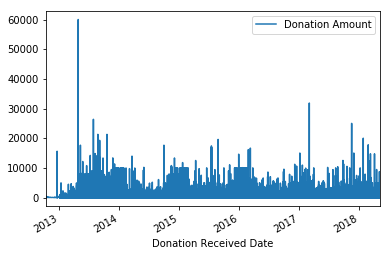

In [33]:
df2.plot(x='Donation Received Date', y='Donation Amount', kind='line')
plt.show()


Okay this is interesting, there is definitely some seasonality to the donations, as can be seen by the hills and valleys in the graph. Monetary value is generally only a proxy for the frequency of donations. We may want to consider how we might further draw out the relationships for Recency-Frequency-Monetary Value. There are a couple of very large donations which are highlighted by the large spikes in the graph. No doubt, these were likely donations by organisations rather than private individuals. 

